<a href="https://www.kaggle.com/code/yaesnurma/ml-algorithms?scriptVersionId=216082121" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from zipfile import ZipFile 
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score,validation_curve,train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore') 

In [3]:
# with ZipFile(r"ZİP_PATH", 'r') as zObject:  
# 	zObject.extractall(path=r"EXTRACT_PATH") 

# Data Preview

In [4]:
data=pd.read_csv(r"/kaggle/input/hitters/hitters.csv")
data

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.000,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.000,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.000,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.000,A


In [5]:
def data_preview(dataframe):
    print("Shape : " , dataframe.shape)
    print("\n**************************************************************************\n")

    print("info : ", dataframe.info())
    print("\n**************************************************************************\n")
    
    print("null:" , dataframe.isnull().sum())
    print("\n**************************************************************************\n")

    print("head : \n" , dataframe.head(3))
    print("\n**************************************************************************\n")
    
    print("tail : \n" , dataframe.tail(3))
    print("\n**************************************************************************\n")
    print(dataframe.select_dtypes(exclude="object").describe().T)
    sns.histplot(data=dataframe, x="Salary", kde=True)

Shape :  (322, 20)

**************************************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  

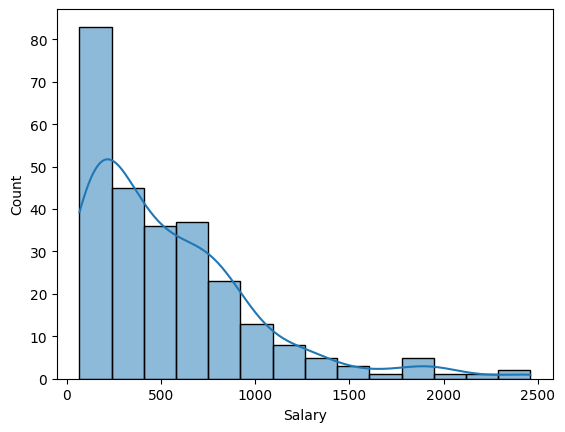

In [6]:
data_preview(data)

In [7]:
list(data.select_dtypes(include=["object"]).columns)

['League', 'Division', 'NewLeague']

In [8]:
def grab_cols(dataframe):
    cat_cols=list(dataframe.select_dtypes(include=["object"]).columns)
    num_but_cat_cols=[col 
                      for col in dataframe.select_dtypes(exclude=["object"]).columns 
                      if len(dataframe[col].unique())<=10 ]
    cat_cols+=num_but_cat_cols
    num_cols=[col for col in dataframe.columns if col not in cat_cols]
    return num_cols,cat_cols

In [9]:
num_cols, cat_cols=grab_cols(data)

In [10]:
print("num cols:\n",num_cols)
print("cat cols:\n",cat_cols)

num cols:
 ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'Salary']
cat cols:
 ['League', 'Division', 'NewLeague']


## Analysis of numerical variables

In [11]:
def visual_num_cols(dataframe,col,figure=False):
    if figure==True:
        plt.figure(figsize=(12,6))
        sns.barplot(data=dataframe,
                    y=col,
                    x=pd.cut(dataframe["Salary"],bins=[0,250,500,750,1000,1250,1500,1750,2000,2250,2500],labels=["0-250","250-500","500-750","750-1000","1000-1250","1250-1500","1500-1750","1750-2000","2000-2250","2250-2500"]),
                    hue=pd.cut(dataframe["Years"],bins=[0,5,10,15,20,25],labels=["0-5","5-10","10-15","15-20","20-25"]),
                    palette="viridis")
        
        plt.show()
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    quan_df=pd.DataFrame(dataframe[col].quantile(quantiles))
    print(quan_df.T,"\n")

In [12]:
for col in num_cols:
    visual_num_cols(dataframe=data,col=col)

        0.050   0.100   0.200   0.300   0.400   0.500   0.600   0.700   0.800   0.900   0.950   0.990
AtBat 161.000 194.100 221.800 281.300 321.800 379.500 430.200 490.000 535.600 584.900 609.900 658.590 

      0.050  0.100  0.200  0.300  0.400  0.500   0.600   0.700   0.800   0.900   0.950   0.990
Hits 39.000 45.100 57.000 70.000 82.000 96.000 113.000 128.700 144.000 163.000 174.000 210.790 

       0.050  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  0.950  0.990
HmRun  0.000  1.000  3.000  5.000  6.000  8.000 10.600 14.000 18.000 24.000 28.950 33.000 

      0.050  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  0.950   0.990
Runs 17.000 20.100 27.000 33.000 41.000 48.000 55.600 66.000 75.800 89.000 94.000 107.790 

     0.050  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  0.950   0.990
RBI 14.000 19.000 26.000 30.000 36.400 44.000 49.000 58.000 73.000 86.000 96.000 112.370 

       0.050  0.100  0.200  0.300  0.400  0.500  0.600  0.

## Analysis of categorical variables

In [13]:
def visual_cat_cols(dataframe, col):
    
    print(pd.DataFrame({col: dataframe[col].value_counts(),
                        "Ratio": 100 * dataframe[col].value_counts() / len(dataframe)}))

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title(f"{col} vs Years")
    plt.xticks(rotation=75)
    sns.countplot(
        data=dataframe,
        x=col,
        hue=pd.cut(dataframe["Years"], bins=[0, 5, 10, 15, 20, 25], labels=["0-5", "5-10", "10-15", "15-20", "20-25"]),
        palette="crest"
    )
    bars = plt.gca().containers
    for bar in bars:
        for rect in bar.patches:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width() / 2, height, int(height), ha='center', va='bottom')

    plt.subplot(1, 2, 2)
    plt.title(f"{col} vs Salary")
    sns.countplot(
        data=dataframe,
        x=col,
        hue=pd.cut(dataframe["Salary"], bins=[0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500],
                   labels=["0-250", "250-500", "500-750", "750-1000", "1000-1250", "1250-1500", "1500-1750", "1750-2000", "2000-2250", "2250-2500"]),
        palette="crest"
    )
    bars = plt.gca().containers
    for bar in bars:
        for rect in bar.patches:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width() / 2, height, int(height), ha='center', va='bottom')


    plt.tight_layout()
    plt.show()


        League  Ratio
League               
A          175 54.348
N          147 45.652


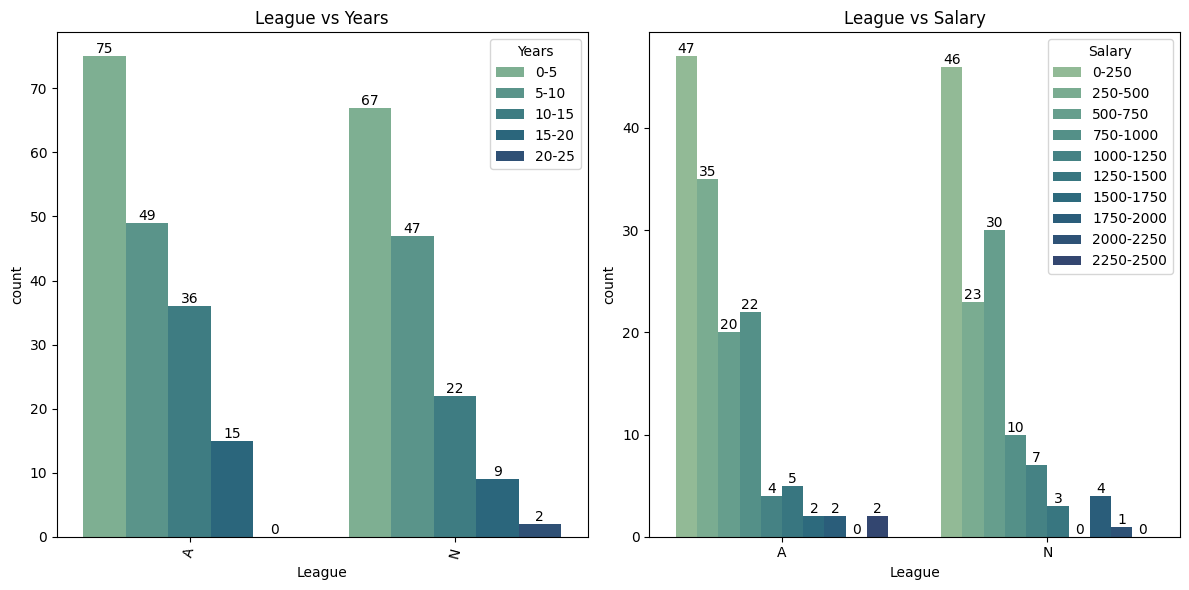

          Division  Ratio
Division                 
W              165 51.242
E              157 48.758


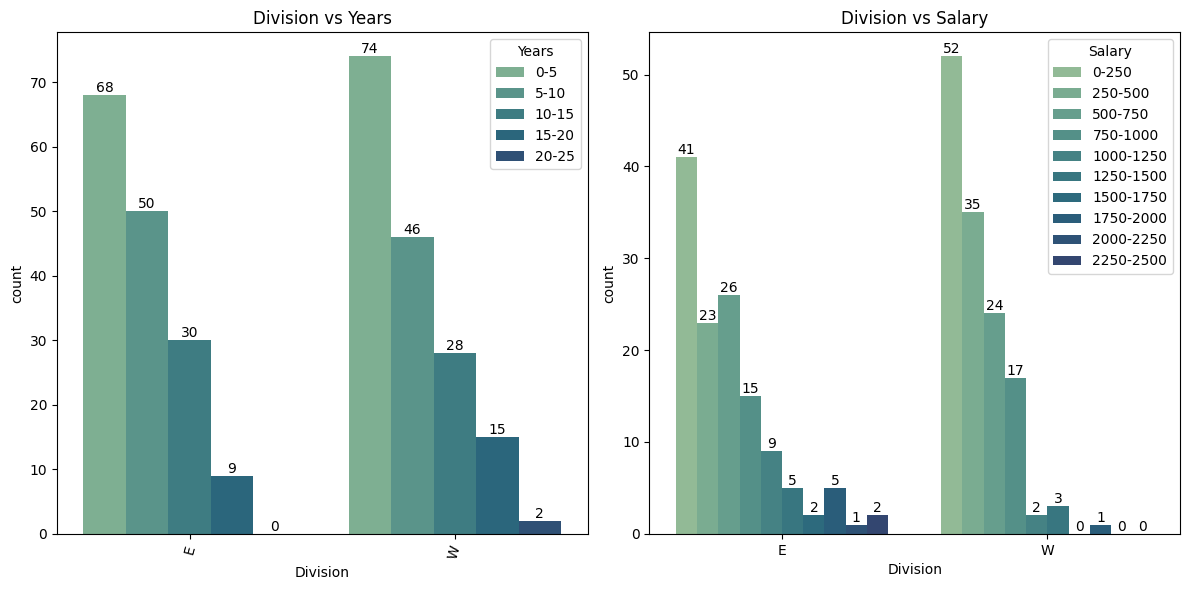

           NewLeague  Ratio
NewLeague                  
A                176 54.658
N                146 45.342


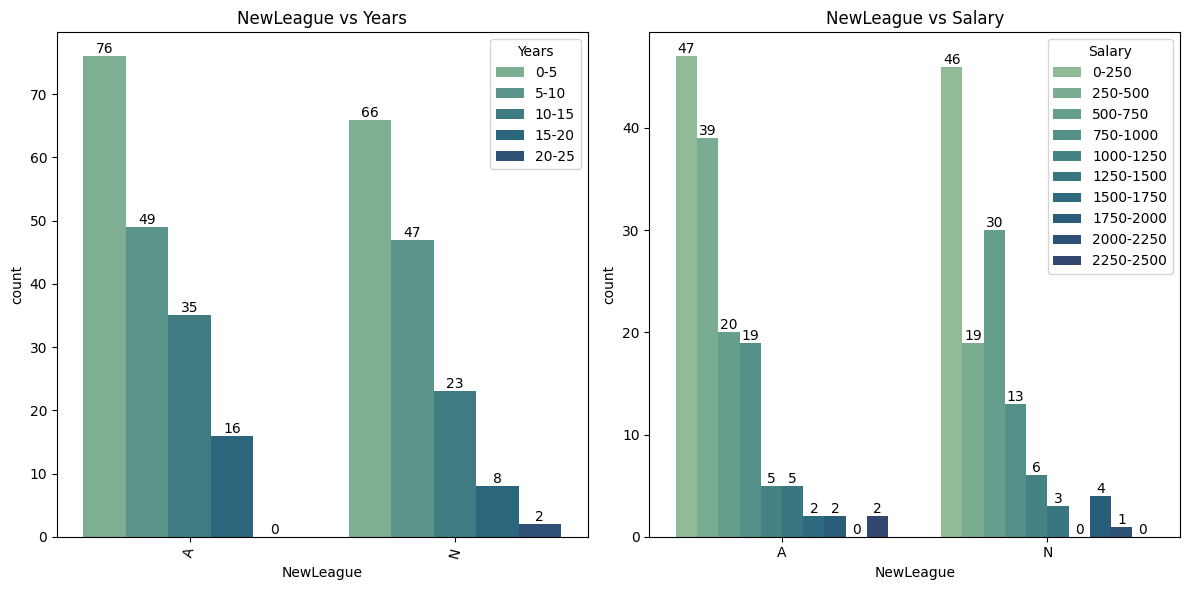

In [14]:
for col in cat_cols:
    visual_cat_cols(data,col)

In [15]:
print(data["League"].value_counts())
y=[indx for indx , val in enumerate(data[["NewLeague","League"]].values) if val[0]!=val[1]]

League
A    175
N    147
Name: count, dtype: int64


        League  Ratio
League               
N           10 52.632
A            9 47.368


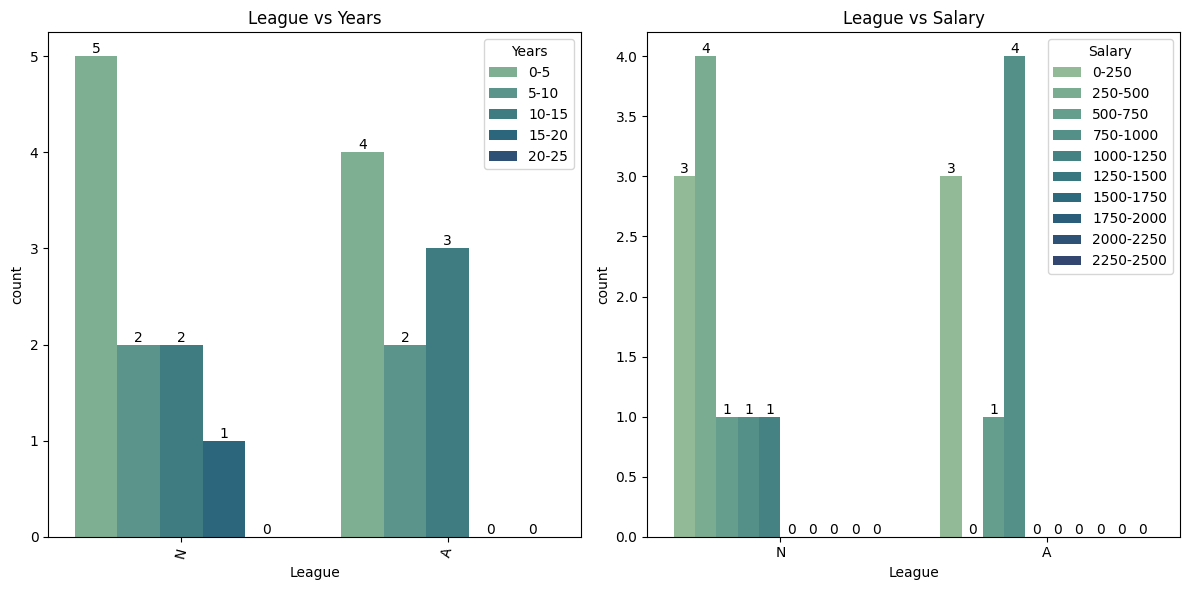

          Division  Ratio
Division                 
E               10 52.632
W                9 47.368


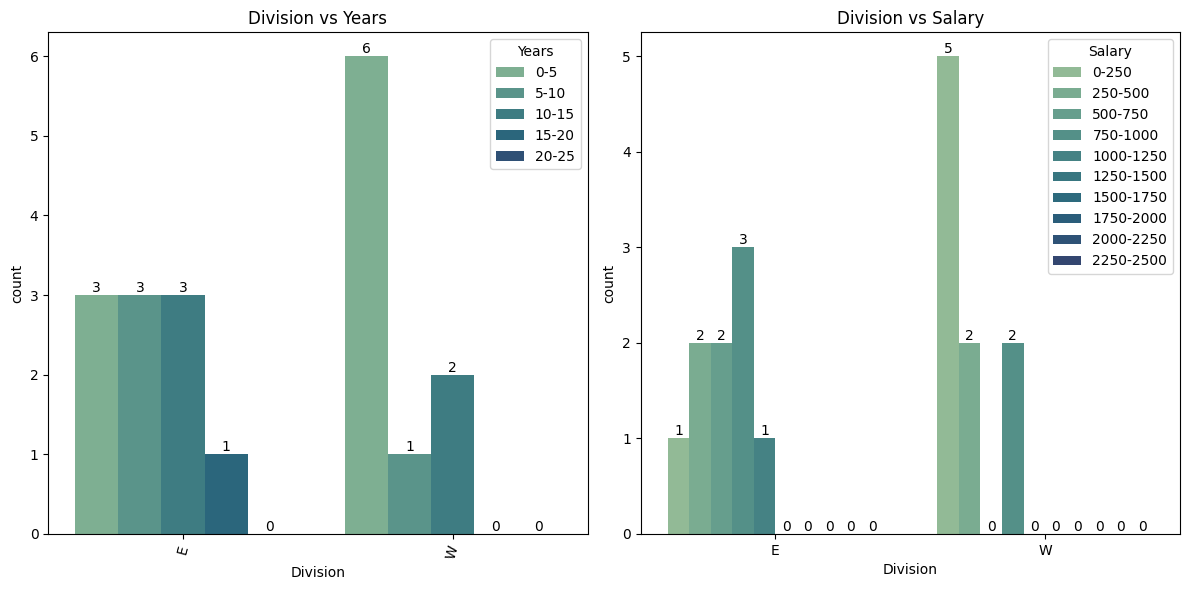

In [16]:
for col in cat_cols[:2]:
    visual_cat_cols(data.loc[y,:],col)

## Analysis of target variables

In [17]:
def target_summary_with_cat(dataframe, target, categorical_col):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(data, "Salary", col)



        TARGET_MEAN
League             
A           542.000
N           529.118


          TARGET_MEAN
Division             
E             624.271
W             450.877


           TARGET_MEAN
NewLeague             
A              537.113
N              534.554




## Analysis of Correlation

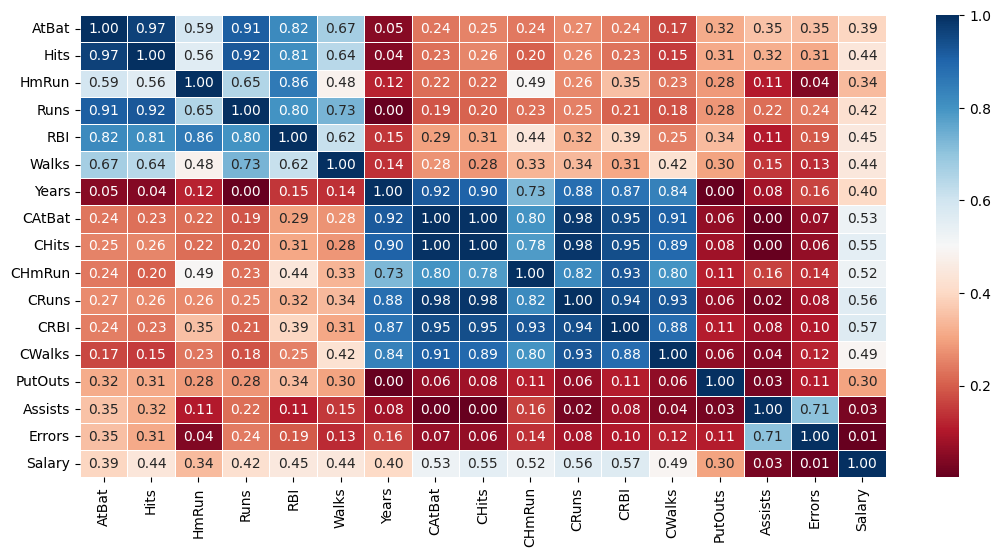

In [18]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    plt.figure(figsize=(13,6))
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        sns.heatmap(cor_matrix, cmap="RdBu", annot=True, fmt=".2f", linewidths=0.5)
        plt.show()
    return drop_list

drop_list=high_correlated_cols(data[num_cols], plot=True)


# EDA (Exploratory Data Analysis)

## Outlier Dedection

In [19]:
def visual_outlier_observations(dataframe,col,figure=False):
    if figure:
        plt.figure(figsize=(10, 4))
        sns.boxplot(data=dataframe[col], orient="h", palette="viridis")
        plt.show()
        
    print(
        "median",np.median(dataframe[col]),
        "\n",
        dataframe[col].describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])
        )

for col in num_cols:
    visual_outlier_observations(dataframe=data,col=col)

median 379.5 
 count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
25%     255.250
50%     379.500
75%     512.000
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64
median 96.0 
 count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
25%      64.000
50%      96.000
75%     137.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64
median 8.0 
 count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
25%       4.000
50%       8.000
75%      16.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64
median 48.0 
 count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
25%      30.250
50%      48.000
75%      69.000
90%      89.000
95%      94.000
99%     107.790
max     130.000
Name: Runs, dtype: float64
me

In [20]:
def outlier_thresholds(dataframe, col, q1=0.25, q3=0.75):
    quartile1 = dataframe[col].quantile(q1)
    quartile3 = dataframe[col].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col, q1, q3)
    if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, col, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col, q1, q3)
    if low_limit > 0:
        dataframe.loc[dataframe[col] < low_limit, col] = low_limit
        dataframe.loc[dataframe[col] > up_limit, col] = up_limit
    else:
        dataframe.loc[dataframe[col] > up_limit, col] = up_limit



In [21]:
for col in num_cols:
    print(f"{col} : {check_outlier(data, col)}")

AtBat : False
Hits : False
HmRun : True
Runs : True
RBI : True
Walks : True
Years : True
CAtBat : True
CHits : True
CHmRun : True
CRuns : True
CRBI : True
CWalks : True
PutOuts : True
Assists : True
Errors : True
Salary : True


In [22]:
for col in num_cols:
    print(f"{col} : {check_outlier(data, col)}\n")
    replace_with_thresholds(data, col)
    print(f"{col} : {check_outlier(data, col)}\n")
    print("**********************************")

AtBat : False

AtBat : False

**********************************
Hits : False

Hits : False

**********************************
HmRun : True

HmRun : False

**********************************
Runs : True

Runs : False

**********************************
RBI : True

RBI : False

**********************************
Walks : True

Walks : False

**********************************
Years : True

Years : False

**********************************
CAtBat : True

CAtBat : False

**********************************
CHits : True

CHits : False

**********************************
CHmRun : True

CHmRun : False

**********************************
CRuns : True

CRuns : False

**********************************
CRBI : True

CRBI : False

**********************************
CWalks : True

CWalks : False

**********************************
PutOuts : True

PutOuts : False

**********************************
Assists : True

Assists : False

**********************************
Errors : True

Errors : False

***

## Missing Values

In [23]:
def missing_values_table(dataframe):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['Missing_Records', 'Ratio'])
    print(missing_df)
    return variables_with_na

In [24]:
def visual_missing_values(dataframe):
    missing_values_table(dataframe)
    plt.figure(figsize=(6, 4))
    sns.heatmap(dataframe.isnull(), cbar=False, cmap='summer')
    plt.show()

        Missing_Records  Ratio
Salary               59 18.320


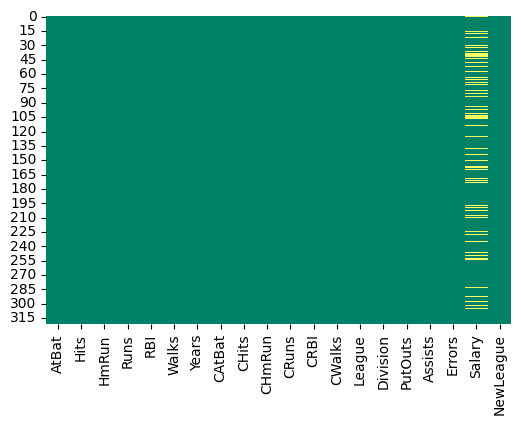

In [25]:
visual_missing_values(data)

In [26]:
df=data.copy().dropna()

## Feautre Extraction

In [27]:
df[num_cols]=df[num_cols]+0.0000000000000000001

In [28]:
df['NEW_Hits'] = df['Hits'] / df['CHits'] + df['Hits']
df['NEW_RBI'] = df['RBI'] / df['CRBI']
df['NEW_Walks'] = df['Walks'] / df['CWalks']
df['NEW_PutOuts'] = df['PutOuts'] * df['Years']
df["Hits_Success"] = (df["Hits"] / df["AtBat"]) * 100
df["NEW_CRBI*CATBAT"] = df['CRBI'] * df['CAtBat']
df["NEW_RBI"] = df["RBI"] / df["CRBI"]
df["NEW_Chits"] = df["CHits"] / df["Years"]
df["NEW_CHmRun"] = df["CHmRun"] * df["Years"]
df["NEW_CRuns"] = df["CRuns"] / df["Years"]
df["NEW_Chits"] = df["CHits"] * df["Years"]
df["NEW_RW"] = df["RBI"] * df["Walks"]
df["NEW_RBWALK"] = df["RBI"] / df["Walks"]
df["NEW_CH_CB"] = df["CHits"] / df["CAtBat"]
df["NEW_CHm_CAT"] = df["CHmRun"] / df["CAtBat"]
df['NEW_Diff_Atbat'] = df['AtBat'] - (df['CAtBat'] / df['Years'])
df['NEW_Diff_Hits'] = df['Hits'] - (df['CHits'] / df['Years'])
df['NEW_Diff_HmRun'] = df['HmRun'] - (df['CHmRun'] / df['Years'])
df['NEW_Diff_Runs'] = df['Runs'] - (df['CRuns'] / df['Years'])
df['NEW_Diff_RBI'] = df['RBI'] - (df['CRBI'] / df['Years'])
df['NEW_Diff_Walks'] = df['Walks'] - (df['CWalks'] / df['Years'])

## Encoding

In [29]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Runs,NEW_Diff_RBI,NEW_Diff_Walks,League_N,Division_W,NewLeague_N
1,315.000,81.000,7.000,24.000,38.000,39.000,14.000,3449.000,835.000,69.000,321.000,414.000,375.000,632.000,43.000,10.000,475.000,81.097,0.092,0.104,8848.000,25.714,1427886.000,11690.000,966.000,22.929,1482.000,0.974,0.242,0.020,68.643,21.357,2.071,1.071,8.429,12.214,True,True,True
2,479.000,130.000,18.000,66.000,72.000,76.000,3.000,1624.000,457.000,63.000,224.000,266.000,263.000,648.625,82.000,14.000,480.000,130.284,0.271,0.289,1945.875,27.140,431984.000,1371.000,189.000,74.667,5472.000,0.947,0.281,0.039,-62.333,-22.333,-3.000,-8.667,-16.667,-11.667,False,True,False
3,496.000,141.000,20.000,65.000,78.000,37.000,11.000,5628.000,1575.000,204.000,828.000,838.000,354.000,200.000,11.000,3.000,500.000,141.090,0.093,0.105,2200.000,28.427,4716264.000,17325.000,2244.000,75.273,2886.000,2.108,0.280,0.036,-15.636,-2.182,1.455,-10.273,1.818,4.818,True,False,True
4,321.000,87.000,10.000,39.000,42.000,30.000,2.000,396.000,101.000,12.000,48.000,46.000,33.000,648.625,40.000,4.000,91.500,87.861,0.913,0.909,1297.250,27.103,18216.000,202.000,24.000,24.000,1260.000,1.400,0.255,0.030,123.000,36.500,4.000,15.000,19.000,13.500,True,False,True
5,594.000,169.000,4.000,74.000,51.000,35.000,11.000,4408.000,1133.000,19.000,501.000,336.000,194.000,282.000,404.500,23.000,750.000,169.149,0.152,0.180,3102.000,28.451,1481088.000,12463.000,209.000,45.545,1785.000,1.457,0.257,0.004,193.273,66.000,2.273,28.455,20.455,17.364,False,True,False


In [30]:
num_cols = [col for col in num_cols if col not in ["Salary","Years"]]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Runs,NEW_Diff_RBI,NEW_Diff_Walks,League_N,Division_W,NewLeague_N
1,-0.603,-0.596,-0.530,-1.207,-0.522,-0.097,14.000,0.373,0.201,0.110,-0.113,0.366,0.592,2.072,-0.528,0.242,475.000,81.097,0.092,0.104,8848.000,25.714,1427886.000,11690.000,966.000,22.929,1482.000,0.974,0.242,0.020,68.643,21.357,2.071,1.071,8.429,12.214,True,True,True
2,0.513,0.492,0.738,0.442,0.795,1.615,3.000,-0.461,-0.418,0.012,-0.425,-0.169,0.081,2.163,-0.242,0.877,480.000,130.284,0.271,0.289,1945.875,27.140,431984.000,1371.000,189.000,74.667,5472.000,0.947,0.281,0.039,-62.333,-22.333,-3.000,-8.667,-16.667,-11.667,False,True,False
3,0.628,0.736,0.969,0.403,1.027,-0.189,11.000,1.369,1.413,2.305,1.518,1.898,0.496,-0.301,-0.762,-0.871,500.000,141.090,0.093,0.105,2200.000,28.427,4716264.000,17325.000,2244.000,75.273,2886.000,2.108,0.280,0.036,-15.636,-2.182,1.455,-10.273,1.818,4.818,True,False,True
4,-0.562,-0.462,-0.184,-0.618,-0.367,-0.513,2.000,-1.022,-1.002,-0.817,-0.991,-0.964,-0.969,2.163,-0.550,-0.712,91.500,87.861,0.913,0.909,1297.250,27.103,18216.000,202.000,24.000,24.000,1260.000,1.400,0.255,0.030,123.000,36.500,4.000,15.000,19.000,13.500,True,False,True
5,1.295,1.358,-0.876,0.757,-0.019,-0.282,11.000,0.812,0.689,-0.704,0.466,0.084,-0.234,0.150,2.118,2.307,750.000,169.149,0.152,0.180,3102.000,28.451,1481088.000,12463.000,209.000,45.545,1785.000,1.457,0.257,0.004,193.273,66.000,2.273,28.455,20.455,17.364,False,True,False


# Modeling

In [31]:
y=df["Salary"]
X=df.drop(["Salary"],axis=1)

## best model selection

In [32]:
models = [
    ('LR', LinearRegression()),
    ("Ridge", Ridge()),
    ("Lasso", Lasso()),
    ("ElasticNet", ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor()),
    ('RF', RandomForestRegressor()),
    ('SVR', SVR()),
    ('GBM', GradientBoostingRegressor()),
    ("XGBoost", XGBRegressor(objective='reg:squarederror', verbosity=0)),
    ("LightGBM", LGBMRegressor(verbose=-1))  
]

rmse = [
    [
        name,
        round(
            float(
                np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, verbose=0, scoring="neg_mean_squared_error")))),4)
    ] 
    for name, regressor in models
]

for i in rmse:
    print(f"RMSE: {i[1]} ({i[0]})")


RMSE: 236.0151 (LR)
RMSE: 232.3599 (Ridge)
RMSE: 227.5263 (Lasso)
RMSE: 277.0181 (ElasticNet)
RMSE: 296.8147 (KNN)
RMSE: 288.0503 (CART)
RMSE: 205.5318 (RF)
RMSE: 397.695 (SVR)
RMSE: 199.013 (GBM)
RMSE: 217.892 (XGBoost)
RMSE: 227.8724 (LightGBM)


In [33]:

from sklearn.model_selection import GridSearchCV

gbm_model = GradientBoostingRegressor(random_state=17)

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]
              }
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.20, random_state=46)



In [34]:
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=1, verbose=1).fit(X, y)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [35]:
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X_train, y_train)
rmse = np.mean(np.sqrt(-cross_val_score(gbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse


204.63921643852808

## Feature Importance

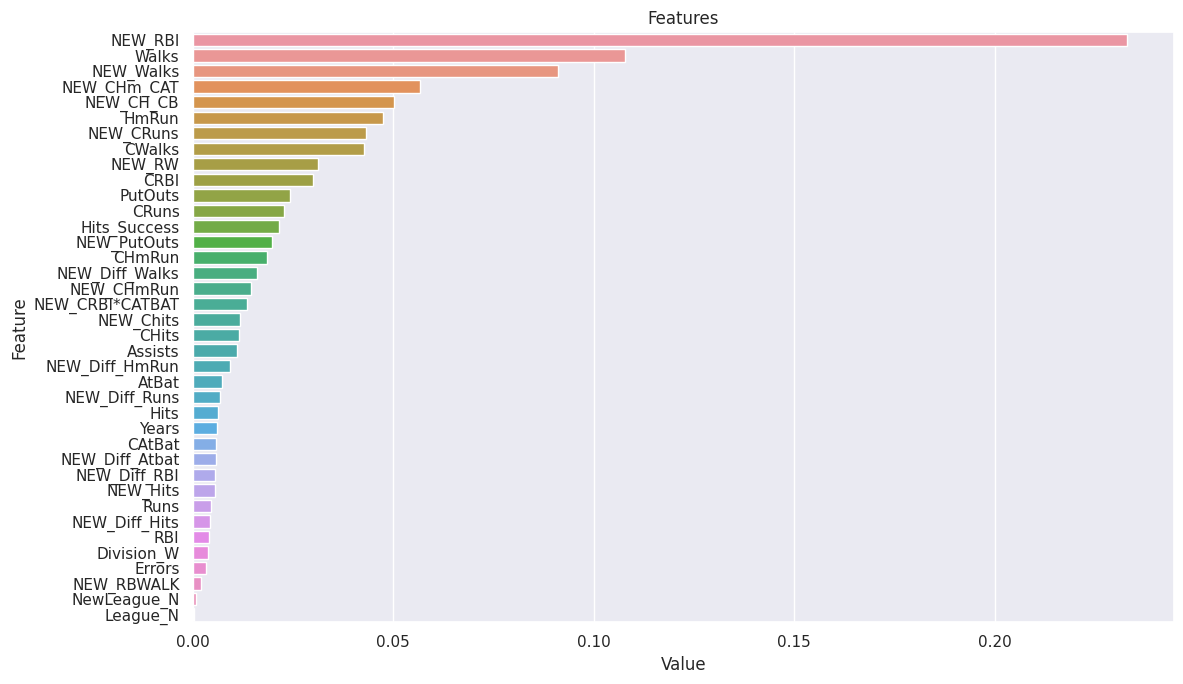

In [36]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(12, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(gbm_final, X)


## Model complexity with learning curves

In [37]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

Mean Squared Error: 69192.59
R-squared Score: 0.56


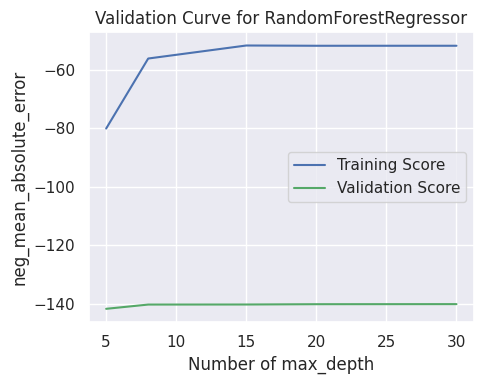

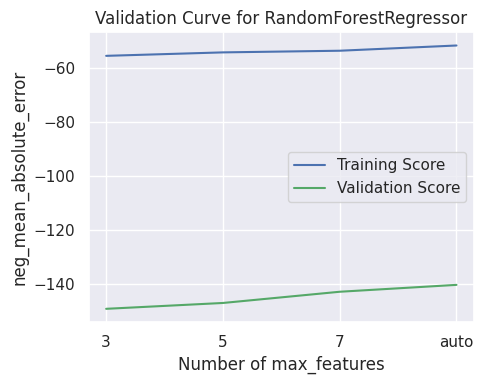

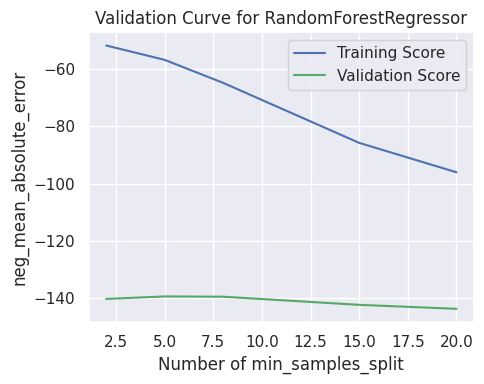

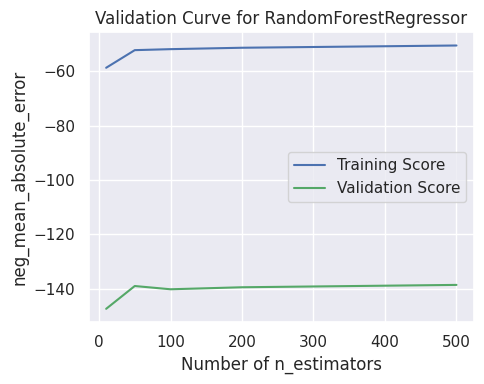

[5, 8, 15, 20, 30, None]

In [38]:

def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    plt.figure(figsize=(5, 4))

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()


rf_val_params = [["max_depth", [5, 8, 15, 20, 30, None]],
                 ["max_features", [3, 5, 7, "auto"]],
                 ["min_samples_split", [2, 5, 8, 15, 20]],
                 ["n_estimators", [10, 50, 100, 200, 500]]]


rf_model = RandomForestRegressor(random_state=17)

for i in range(len(rf_val_params)):
    val_curve_params(rf_regressor, X, y, rf_val_params[i][0], rf_val_params[i][1],scoring="neg_mean_absolute_error")

rf_val_params[0][1]